# <center>Feedforward and Backpropagation</center>
## <center>Inclass Project 2 - MA4144</center>

This project contains 12 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle and also the ipynb notebook file as well**.

***

## Outline of the project

The aim of the project is to build a Multi Layer perceptron (MLP) model from scratch for binary classification. That is given an input $x$ output the associated class label $0$ or $1$.

In particular, we will classify images of handwritten digits ($0, 1, 2, \cdots, 9$). For example, given a set of handwritten digit images that only contain two digits (Eg: $1$ and $5$) the model will classify the images based on the written digit.

For this we will use the MNIST dataset (collection of $28 \times 28$ images of handwritten digits) - you can find additional information about MNIST [here](https://en.wikipedia.org/wiki/MNIST_database).

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" width="250">

***


Use the below cell to use any include any imports

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

## Section 1: Preparing the data

In [65]:
#Load the dataset as training and testing, then print out the shapes of the data matrices.
#The training data will be provided to you.

data = np.load('train_mnist.npz')
train_X = data['x']
train_y = data['y']
print(train_X.shape)
print(train_y.shape)

(60000, 28, 28)
(60000,)


**Q1.** In the following cell write code to display $5$ random images in train_X and it's corresponding label in train_y. Each time it is run, you should get a different set of images. The imshow function in the matplotlib library could be useful. Display them as [grayscale images](https://en.wikipedia.org/wiki/Grayscale).

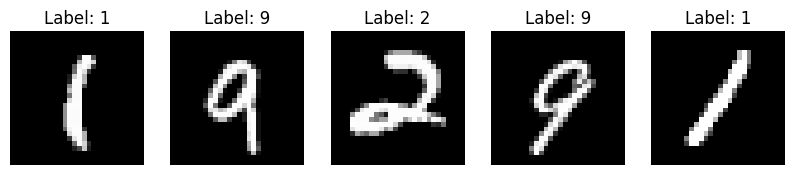

In [66]:
indices = np.random.choice(len(train_X), 5, replace=False)  

plt.figure(figsize=(10, 5))
for i, index in enumerate(indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_X[index], cmap='gray')
    plt.title(f"Label: {train_y[index]}")
    plt.axis('off')

plt.show()

**Q2.** Given two digits $d_1$ and $d_2$, both between $0$ and $9$, in the following cell fill in the function body to extract all the samples corresponding to $d_1$ or $d_2$ only, from the dataset $X$ and labels $y$. You can use the labels $y$ to filter the dataset. Assume that the label for the $_i$th image $X[i]$ in $X$ is given by $y[i]$. The function should return the extracted samples $X_{extracted}$ and corresponding labels $y_{extracted}$. Avoid using for loops as much as possible, infact you do not need any for loops. numpy.where function should be useful.

In [ ]:
def extract_digits(X, y, d1, d2):

    assert d1 in range(0, 10), "d1 should be a number between 0 and 9 inclusive"
    assert d2 in range(0, 10), "d2 should be a number between 0 and 9 inclusive"
    
    indices = np.where((y == d1) | (y == d2))  
    
    X_extracted = X[indices]
    y_extracted = y[indices]
    
    return (X_extracted, y_extracted)

**Q3.** Both the training dataset is a 3 dimensional numpy array, each image occupies 2 dimensions. For convenience of processing data we usually comvert each $28 \times 28$ image matrix to a vector with $784$ entries. We call this process **vectorize images**.

Once we vectorize the images, the vectorized data set would be structured as follows: $i$th row will correspond to a single image and $j$th column will correspond to the $j$th pixel value of each vectorized image. However going along with the convention we discussed in the lecture, the input to the MLP model will require that the columns correspond to individual images. Hence we also require a transpose of the vectorized results.

The pixel values in the images will range from $0$ to $255$. Normalize the pixel values between $0$ and $1$, by dividing each pixel value of each image by the maximum pixel value of that image. Simply divide each column of the resulting matrix above by the max of each column. 

<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTdN_8m9FEqjqAB07obTmB6gNc7S2rSoGBYaA&s"></center>

Given a dataset $X$ of size $N \times 28 \times 28$, in the following cell fill in the function to do the following in order;
1. Vectorize the dataset resulting in dataset of size $N \times 784$.
2. Transpose the vectorized result.
3. Normalize the pixel values of each image.
4. Finally return the vectorized, transposed and normalized dataset $X_{transformed}$.

Again, avoid for loops, functions such as numpy.reshape, numpy.max etc should be useful.

In [68]:
def vectorize_images(X):
    input_vec=X.reshape(X.shape[0], X.shape[1]*X.shape[2])
    transpose_vec=input_vec.T
    X_vectorized = transpose_vec / np.max(transpose_vec, axis=0)
    return(X_vectorized)

**Q4.** In the following cell write code to;

1. Extract images of the digits $d_1 = 1$ and $d_2 = 5$ with their corresponding labels for the training set (train_X, train_y).
2. Then vectorize the data, tranpose the result and normlize the images.
3. Store the results after the final transformations in numpy arrays train_X_1_5, train_y_1_5.
4. Our MLP will output only class labels $0$ and $1$ (not $1$ and $5$), so create numpy arrays to store the class labels as follows:
   $d_1 = 1$ -> class label = 0 and $d_2 = 5$ -> class label = 1. Store them in an array named train_y_1_5.

Use the above functions you implemented above to complete this task. In addtion, numpy.where could be useful. Avoid for loops as much as possible.

In [69]:
d1=1
d2=5

train_X_extracted, train_y_extracted = extract_digits(train_X, train_y, d1, d2)

train_X_1_5 = vectorize_images(train_X_extracted)
temp_train_y_1_5 = train_y_extracted
train_y_1_5 = np.where(temp_train_y_1_5 == d1, 0, 1)

## Section 2: Implementing MLP from scratch with training algorithms.

Now we will implement code to build a customizable MLP model. The hidden layers will have the **Relu activation function** and the final output layer will have **Sigmoid activation function**.

**Q5.** Recall the following about the activation functions:
1. Sigmoid activation: $y = \sigma(z) = \frac{1}{1 + e^{-z}}$.
2. Derivative of Sigmoid: $y' = \sigma'(z) = \sigma(z) (1 - \sigma(z)) = y(1-y)$
3. ReLu activation: $y = ReLu(z) = max(0, z)$
4. Derivative of ReLu: $y' = ReLu'(z) = \begin{cases} 0 \; \textrm{if } z < 0 \\ 1 \; \textrm{otherwise} \end{cases} = \begin{cases} 0 \; \textrm{if } y = 0 \\ 1 \; \textrm{otherwise} \end{cases}$

In the following cell implement the functions to compute activation functions Sigmoid and ReLu given $z$ and derivatives of the Sigmoid and ReLu activation functions given $y$. Note that, in the implementation, the derivative functions should actually accept $y$ as the input not $z$.

In practice the input will not be just single numbers, but matrices. So functions or derivatives should be applied elementwise on matrices. Again avoid for loops, use the power of numpy arrays - search for numpy's capability of doing elementwise computations.

Important: When implementing the sigmoid function make sure you handle overflows due to $e^{-z}$ being too large. To avoid you can choose to set the sigmoid value to 'the certain appropriate value' if $z$ is less than a certain good enough negative threshold. If you do not handle overflows, the entire result will be useless since the MLP will just output Nan (not a number) for every input at the end.

In [70]:
def sigmoid(Z):

    temp_Z = np.clip(Z,-500,500)
    sigma = 1 / (1 + np.exp(-temp_Z))
    
    return(sigma)

def deriv_sigmoid(Y):

    sigma_prime = Y * (1 - Y)
    
    return(sigma_prime)
    

def ReLu(Z):

    relu = np.maximum(0, Z)
    
    return(relu)

def deriv_ReLu(Y):

    relu_prime = np.where(Y > 0, 1, 0)
    
    return(relu_prime)


**Q6.** The following piece of code defines a simple MLP architecture as a Python class and subsequent initialization of a MLP model. <font color='blue'>Certain lines of code contains commented line numbers. Write a short sentence for each such line explaining its purpose. Feel free to refer to the lecture notes or any resources to answers these question. In addition, explain what the Y, Z, W variables refer to and their purpose</font>

In [71]:
class NNet:
    def __init__(self, input_size = 784, output_size = 1, batch_size = 1000, hidden_layers = [500, 250, 50]):
        self.Y = []
        self.Z = []
        self.W = []
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.hidden_layers = hidden_layers

        layers = [input_size] + hidden_layers + [output_size]
        L = len(hidden_layers) + 1
    
        for i in range(1, L + 1):
            self.Y.append(np.zeros((layers[i], batch_size)))                        #line1
            self.Z.append(np.zeros((layers[i], batch_size)))                        #Line2
            self.W.append(2*(np.random.rand(layers[i], layers[i-1] + 1) - 0.5))     #Line3

**Answers** (to write answers edit this cell)

(i) What does the Y, Z, W variables refer to and their purpose?

<font color='blue'>Y - Stores the activated output of each layer. The value in Z passes through an activation function (Relu or Sigmoid) and saves the results.</font>

<font color='blue'>Z - Stores the linear transformation output before applying activation functions. Store values in each layer Computed as, Z=W⋅X+b.</font> 
  
<font color='blue'>W - Stores the weight matrices for each layer. These are the values adjusted in the training process.</font>

(ii) Line1: Explanation

<font color='blue'>Initializes the activation matrix (Y) for each layer with zeros.
Shape is neurons in the (current layer, batch_size).</font>

(iii) Line2: Explanation

<font color='blue'>Initializes the pre-activation matrix (Z) for each layer with zeros
Shape is same as Y, (current layer, batch_size).</font>

(iv) Line3: Explanation

<font color='blue'>Initializes the weight matrix (W) for each layer with random values in the range [-1, 1].
shape is (neurons in current layer, neurons in previous layer + 1).
The +1 accounts for the bias term.
np.random.rand() generates values in [0,1], subtracting 0.5 shifts it to [-0.5, 0.5], multiplying by 2 scales it to [-1,1], ensuring diverse initial weights.</font>

**Q7.** Now we will implement the feedforward algorithm. Recall from the lectures that for each layer $l$ there is input $Y^{(l-1)}$ from the previous layer if $l > 1$ and input data $X$ if $l = 1$. Then we compute $Z^{(l)}$ using the weight matrix $W^{(l)}$ as follows from matrix multiplication:

$Z^{(l)} = W^{(l)} Y^{(l-1)}$

Make sure that during multiplication you add an additional row of one's to $Y^{(l-1)}$ to accommodate the bias term (concatenate the row of ones as the last row to be consistent with the grader). However, the rows of ones should not permanently remain on $Y^{(l-1)}$. <font color='blue'>Explain what the bias term is and how adding a row of one's help with the bias terms.</font> The weight matrices are initialised to afford this extra bias term, so no change to either $Z^{(l)}$ or $W^{(l)}$ is needed.

Next compute $Y^{(l)}$, the output of layer $l$ by activation through sigmoid.

$Y^{(l)} = \sigma(Z^{(l)})$

The implemented feedforward algorithm should take in a NNet model and an input matrix $X$ and output the modified MLP model - the $Y$'s and $Z$'s computed should be stored in the model for the backpropagation algorithm.

As usual, avoid for loops as much as possible, use the power of numpy. However, you may use a for loop to iterate through the layers of the model.

In [72]:
def feedforward(model, X):
    layers = len(model.W)
    temp_X=np.vstack([X,np.ones(X.shape[1])])
    model.Z[0] = np.dot(model.W[0], temp_X)
    model.Y[0] = ReLu(model.Z[0])

    for layer in range(1, layers):
        temp=np.vstack([model.Y[layer-1],np.ones(model.Y[layer-1].shape[1])])
        model.Z[layer] = np.dot(model.W[layer], temp)

        if (layer==layers-1):
            model.Y[layer] = sigmoid(model.Z[layer])
        else:
            model.Y[layer] = ReLu(model.Z[layer])

    return(model)

**Answer** (to write answers edit this cell)

Explain what the bias term is and how adding a row of one's help with the bias terms.

<font color='blue'>
bias term is an additional parameter that allows the model to make better predictions by shifting the activation function. It is added to the weighted sum of inputs before applying the activation function.

Adding a row of one's setup allows compute the output using a single matrix multiplication, instead of needing to handle the bias separately, with this method, the bias term becomes part of the weight vector, and no special handling is required for it in the calculations.
</font>



**Q8.** Now we will implement the backpropagation algorithm. The cost function $C$ at the end is given by the square loss.

$C = \frac{1}{2} ||Y^{(L)} - Y||^{2}$, where $Y^{(L)}$ is the final output vector of the feedforward algorithm and $Y$ is the actual label vector associated with the input $X$.

At each layer $l = 1, 2, \cdots, L$ we compute the following (note that the gradients are matrices with the same dimensions as the variable to which we derivating with respect to):

1. Gradient of $C$ with respect to $Z^{(l)}$ as <br> $\frac{\partial C}{\partial Z^{(l)}} = deriv(A^{(l)}(Z^{(l)})) \odot \frac{\partial C}{\partial Y^{(L)}} $, <br> where $A^{(l)}$ is the activation function of the $l$th layer, and we use the derivative of that here. The $\odot$ refers to the elementwise multiplication.

2. Gradient of $C$ with respect to $W^{(l)}$ as <br> $\frac{\partial C}{\partial W^{(l)}} = \frac{\partial C}{\partial Z^{(l)}} (Y^{(l-1)})^{T}$ <br> this is entirely matrix multiplication.

3. Gradient of $C$ with respect to $Y^{(l-1)}$ as <br> $\frac{\partial C}{\partial Y^{(l-1)}} = (W^{(l)})^{T} \frac{\partial C}{\partial Z^{(l)}}$ <br> this is also entirely matrix multiplication.

4. Update weights by: <br> $W^{(l)} \leftarrow W^{(l)} - \eta \frac{\partial C}{\partial W^{(l)}}$, <br> where $\eta > 0$ is the learning rate.

The loss derivative (the gradient of $C$ with respect to $Y^{(L)}$) at the last layer is given by:

$\frac{\partial C}{\partial Y^{(L)}} = Y^{(L)} - Y$

By convention we consider $Y^{(0)} = X$, the input data.

Based on the backpropagation algorithm implement the backpropagation method in the following cell. Remember to temporarily add a row of ones to $Y^{(l-1)}$ (as the last row to be consistent with the grader) when computing $\frac{\partial C}{\partial W^{(l)}}$ as we discussed back in the feedforward algorithm. Make sure you avoid for loops as much as possible.

The function takes in a NNet model, input data $X$ and the corresponding class labels $Y$. learning rate can be set as desired.

In [73]:
def backpropagation(model, X, Y, eta = 0.01):
    layers=len(model.W)

    dc_dy=model.Y[layers-1]-Y

    for layer in range(layers-1, -1, -1):
        if(layer==layers-1):
            dc_dz = deriv_sigmoid(model.Y[layer])*dc_dy
        else:
            dc_dz = deriv_ReLu(model.Y[layer])*dc_dy

        if(layer > 0):
            dc_sw = np.dot(dc_dz, np.vstack([model.Y[layer-1],np.ones(model.Y[layer-1].shape[1])]).T)
        else:
            dc_sw = np.dot(dc_dz, np.vstack([X,np.ones(X.shape[1])]).T)

        model.W[layer] = model.W[layer] - eta*dc_sw

        if layer > 0:
            rm_bias = model.W[layer][:, :-1]  # Remove bias from weight matrix
            dc_dy = np.dot(rm_bias.T, dc_dz)  # Ensure correct shape
            
    return(model)

**Q9.** Now implement the training algorithm.

The training method takes in training data $X$, actual label $Y$, number of epochs, batch_size, learning rate $\eta > 0$. The training will happen in epochs. For each epoch, permute the data columns of both $X$ and $Y$, then divide both $X$ and $Y$ into mini batches each with the given batch size. Then run the feedforward and backpropagation for each such batch iteratively.

At the end of each iteration, keep trach of the cost $C$ and the $l_2$-norm of change in each weight matrix $W^{(l)}$.

At the end of the last epoch, plot the variation cost $C$ and change in weight matrices. Then return the trained model.



In [74]:
def train_NNet(X, Y, epochs=20, batch_size=1000, eta=0.01, hidden_layers=[500, 250, 50], plot=True):
    loss_ = []
    weight_change = []
    np.random.seed(42)  # Setting the random seed for reproducibility

    # Initialize the model
    model = NNet(input_size=X.shape[0], output_size=1, batch_size=batch_size, hidden_layers=hidden_layers)

    num_samples = X.shape[1]  # Total number of data points

    # Going through each epoch
    for i in range(epochs):
        # Permuting the dataset (randomizing order)
        permuted_idx = np.random.permutation(num_samples)
        X_permuted = X[:, permuted_idx]
        Y_permuted = Y[permuted_idx]

        batch_loss = np.array([])
        w_change = 0
        num_minibatches = num_samples // batch_size  # Number of minibatches

        # Going through each minibatch
        for j in range(num_minibatches):
            start_id = j * batch_size
            end_id = min(start_id + batch_size, num_samples)

            X_batch = X_permuted[:, start_id:end_id]
            Y_batch = Y_permuted[start_id:end_id]

            # Forward propagation
            model = feedforward(model, X_batch)

            # Keeping a copy of weights before updating
            prev_w = [np.copy(w) for w in model.W]

            # Backpropagation
            model = backpropagation(model, X_batch, Y_batch, eta)

            # Computing L2 norm of weight changes
            w_change += sum(np.linalg.norm(prev_w[k] - model.W[k]) for k in range(len(model.W)))

            # Compute loss (Mean Squared Error)
            loss = 0.5 * (np.linalg.norm(model.Y[-1] - Y_batch) ** 2)
            batch_loss = np.append(batch_loss, loss)

        # Compute epoch loss
        epoch_loss = np.mean(batch_loss) / batch_size
        weight_change.append(w_change / (num_minibatches * len(model.W)))
        loss_.append(epoch_loss)

    # Plot results if requested
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(10, 8))

        # Plot Training Loss
        ax[0].plot(loss_, color='r')
        ax[0].set_title('Loss vs Epochs')
        ax[0].set_xlabel('Number of Epochs')
        ax[0].set_ylabel('Epoch Loss')
        ax[0].grid(True)

        # Plot Weight Changes
        ax[1].plot(weight_change, color='g')
        ax[1].set_title('Weight Change vs Epochs')
        ax[1].set_xlabel('Number of Epochs')
        ax[1].set_ylabel('Weight Change')
        ax[1].grid(True)

        # Show both plots
        plt.tight_layout()
        plt.show()

    return (model)

## Section 3: Evaluation using test data

**Q10.** Implement the following function predict. Given test images (3 dimensional numpy array that contains $28 \times 28$ digit images) it will correctly recognize the written digits between d1 and d2. You can assume that test_images will only contain images of digits d1 and d2. Inside predict you would need to preprocess the images using vectorize, predict the correct labels using model and then output the correct lables. Output should be a vector predicted of d1's and d2's, predicted[i] should correspond to the test_image[i].

In [75]:
def predict(model, test_images, d1, d2):
    X_vectorized = vectorize_images(test_images)  # Preprocess images
    model = feedforward(model, X_vectorized)  # Forward pass
    
    predicted_probs = model.Y[-1]  # Get final layer outputs
    predicted = (predicted_probs >= 0.5).astype(int)  # Convert probabilities to class labels
    
    # Convert back to original labels (d1 and d2)
    predicted = np.where(predicted == 0, d1, d2)  

    return predicted.reshape(-1)  # Ensure it's a 1D array


**Q11.** Use the train_NNet function to train a MLP model to classify between images of digits $1$ and $5$. An accuracy $>= 99%$ is achievable. Test with different batch sizes, $\eta$ values and hidden layers. Find which of those hyperparameters gives the best test accuracy. Name this model, model_1_5. This model will be tested on unseen test data within the grader. So make sure you train the best possible model. The grader will use your own predict function to evaluate the model.

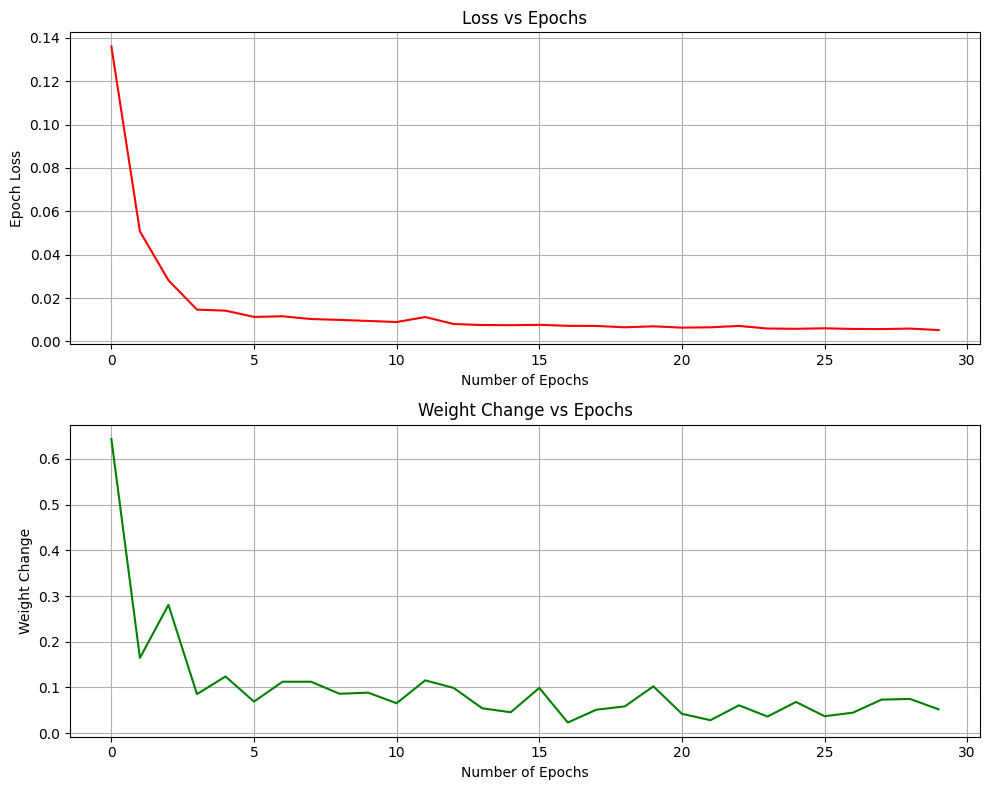

Training Accuracy: 98.77%


In [76]:
# Best Hyperparameters
batch_size = 4000  
eta = 0.001  
epochs = 30
hidden_layers = [500, 250] 

# Model with best hyperparameters
model_1_5 = train_NNet(train_X_1_5, train_y_1_5, epochs=epochs, batch_size=batch_size, eta=eta, hidden_layers=hidden_layers, plot=True)

# Get model predictions on training data
train_predictions = predict(model_1_5, train_X_extracted, d1, d2)

# Compute accuracy
train_accuracy = accuracy_score(train_y_extracted, train_predictions)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


**Q12.** Do the same as in Q11 with the digits $7$ and $9$ Name this model, model_7_9. This model will be tested on unseen test data within the grader. So make sure you train the best possible model. The grader will use your own predict function to evaluate the model.

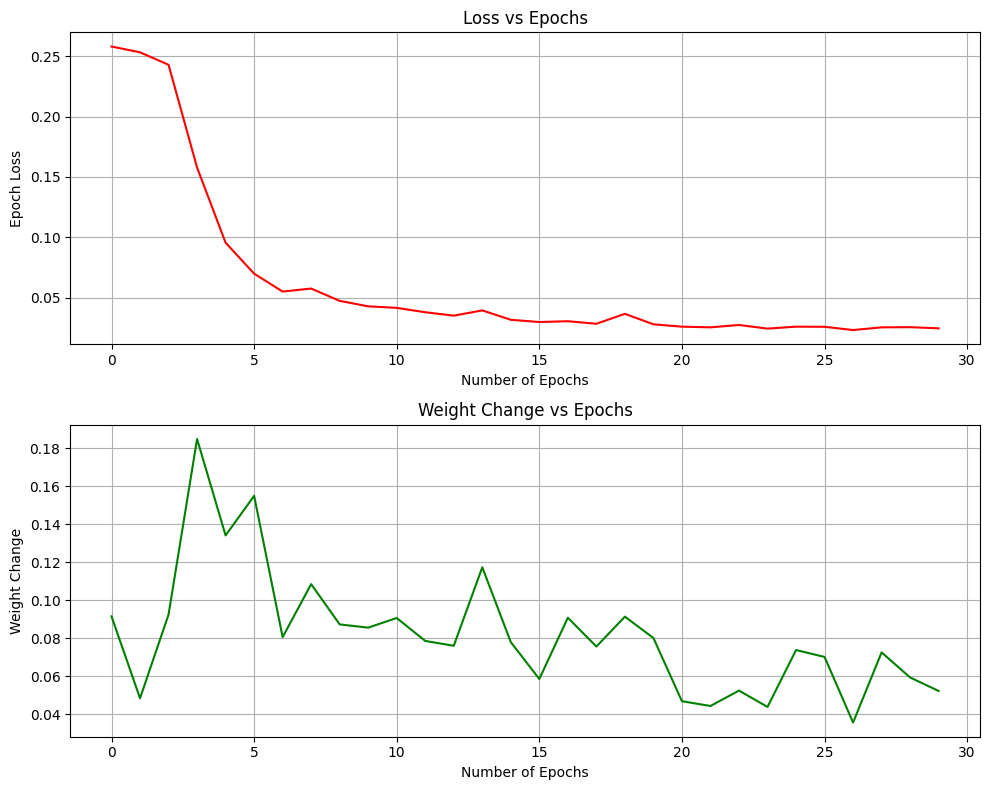

Training Accuracy: 94.96%


In [77]:
d1=7
d2=9

train_X_extracted, train_y_extracted = extract_digits(train_X, train_y, d1, d2)

train_X_7_9 = vectorize_images(train_X_extracted)
temp_train_y_7_9 = train_y_extracted
train_y_7_9 = np.where(temp_train_y_7_9 == d1, 0, 1)

# Best Hyperparameters
batch_size = 1000 
eta = 0.001  
epochs = 30  
hidden_layers = [500, 250] 

# Model with best hyperparameters
model_7_9 = train_NNet(train_X_7_9, train_y_7_9, epochs=epochs, batch_size=batch_size, eta=eta, hidden_layers=hidden_layers, plot=True)

# Get model predictions on training data
train_predictions = predict(model_7_9, train_X_extracted, d1, d2)

# Compute accuracy
train_accuracy = accuracy_score(train_y_extracted, train_predictions)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")




In [78]:
# # Define grid search function
# def grid_search(epochs, batch_sizes, learning_rates, hidden_layers_options, X_train, y_train,d1,d2):
#     best_acc = 0
#     best_params = {
#         'epochs': None,
#         'batch_size': None,
#         'learning_rate': None,
#         'hidden_layers': None
#     }

#     # Iterate over all combinations of hyperparameters
#     for epoch in epochs:
#         for batch_size in batch_sizes:
#             for eta in learning_rates:
#                 for hidden_layers in hidden_layers_options:
#                     print(f"Training with epochs={epoch}, batch_size={batch_size}, eta={eta}, hidden_layers={hidden_layers}")
                    
#                     # Train the model with the current hyperparameters
#                     model = train_NNet(X_train, y_train, epochs=epoch, batch_size=batch_size, eta=eta, hidden_layers=hidden_layers, plot=False)

#                     # Predict on the validation set
#                     predictions = predict(model, X_train, d1, d2)

#                     # Calculate accuracy on validation set
#                     acc = accuracy_score(y_train, predictions)

#                     print(f"Training Accuracy: {acc * 100:.2f}%")
                    
#                     # Update best hyperparameters if the current model performs better
#                     if acc > best_acc:
#                         best_acc = acc
#                         best_params['epochs'] = epoch
#                         best_params['batch_size'] = batch_size
#                         best_params['learning_rate'] = eta
#                         best_params['hidden_layers'] = hidden_layers

#     # Return the best hyperparameters and the corresponding accuracy
#     print(f"Best Hyperparameters: {best_params}")
#     return best_params

# # Example usage
# epochs = [20, 50, 100]
# batch_sizes = [1000, 2000, 4000]
# learning_rates = [0.001, 0.01]
# hidden_layers_options = [[500, 250], [512, 250, 50], [500, 250, 125, 50]]

# # Assuming X_train, y_train, X_val, and y_val are prepared from your dataset
# best_params = grid_search(epochs, batch_sizes, learning_rates, hidden_layers_options, train_X_7_9, train_y_7_9,7,9)
